In [73]:
import openpyxl
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import svm
import datetime
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

import statsmodels.api as sm

import itertools
import optuna

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima_model
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ModuleNotFoundError: No module named 'optuna'

In [65]:
wb1 = openpyxl.load_workbook(r"data_sheets\11111111111111.xlsx")
sheet = wb1['Отчет']

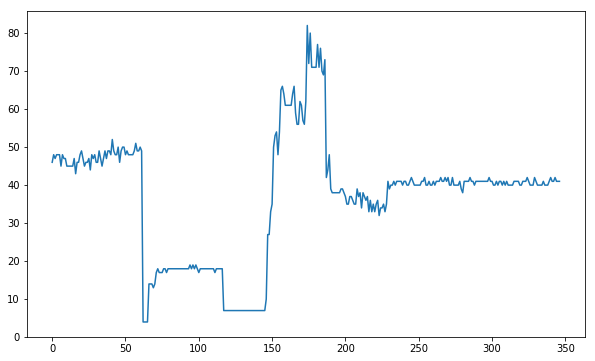

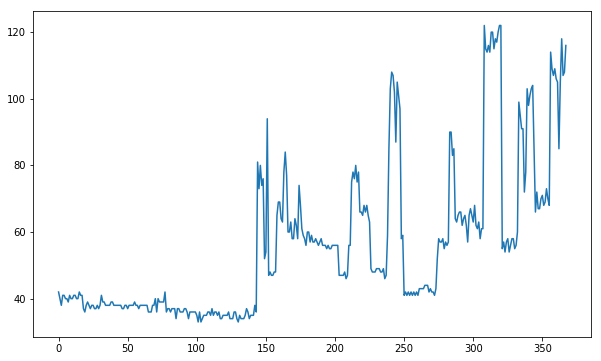

In [66]:
start = datetime.datetime.now()
timer = []
batch_train = []
batch_test = []
n = 18
border = 366
num = 734
for i in range (1, border-n):
    timer.append(sheet.cell(row = i+n, column = 1).value)
    batch_train.append(float(sheet.cell(row = i+n, column = 7).value))
for j in range (border-n, num-n):
    timer.append(sheet.cell(row = j+n, column = 1).value)
    batch_test.append(float(sheet.cell(row = j+n, column = 7).value))
plt.plot(batch_train)
plt.show()
plt.plot(batch_test)
plt.show()

    

In [71]:
df1 =  pd.DataFrame(columns = ["flow1"])
df1.flow1 = batch_test

model1 = SARIMAX(df1, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result1 = model1.fit()

prog_start = 18

pred1 = result1.get_prediction(start = prog_start, dynamic = False)
forecast_values1 = pred1.predicted_mean

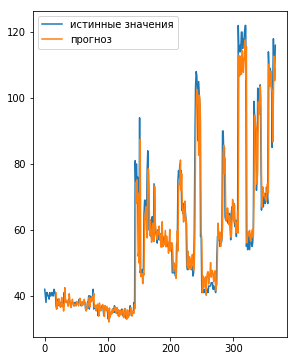

In [72]:
#forecast_mse1 = ((forecast_values1 - batch_test) ** 2).mean()
    
figure = pylab.subplot(1,2,2)
figure1 = pylab.plot(batch_test, label = "истинные значения")
figure2 = pylab.plot(forecast_values1, label = "прогноз")
pylab.legend()